In [ ]:
#Last modified by Les on May 29, 2022

import os
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from PIL import Image

import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
#import pytorch_lightning as pl

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
BasePath = '/content/drive/My Drive/TrutrayImages/'

In [ ]:
Images = []
Labels = []
for File in os.listdir(BasePath):
    if File=='Curved Mayo Scissor':
        for c in os.listdir(os.path.join(BasePath, File)):
            Images.append(c)
            Labels.append('Curved Mayo Scissor')
    if File=='Scalpel':
        for c in os.listdir(os.path.join(BasePath, File)):
            Images.append(c)
            Labels.append('Scalpel')
    if File=='Curved Dissection Clamp':
        for c in os.listdir(os.path.join(BasePath, File)):
            Images.append(c)
            Labels.append('Curved Dissection Clamp')
    if File=='Straight Mayo Scissor':
        for c in os.listdir(os.path.join(BasePath, File)):
            Images.append(c)
            Labels.append('Straight Mayo Scissor')
Data = {'Images':Images, 'Labels':Labels}
Data = pd.DataFrame(Data)
Data.head()

,Images,Labels
0,bisturi373.jpg,Scalpel
1,bisturi163.jpg,Scalpel
2,bisturi412.jpg,Scalpel
3,bisturi244.jpg,Scalpel
4,bisturi16.jpg,Scalpel


In [ ]:
LabelEncode = LabelEncoder()
Data['EncodedLabels'] = LabelEncode.fit_transform(Data['Labels'])

In [ ]:
BatchSize = 128
ValidationSplit = .3
ShuffleDataset = True
RandomSeed= 42

In [ ]:
DatasetSize = len(Data)
Indices = list(range(DatasetSize))
Split = int(np.floor(ValidationSplit * DatasetSize))
if ShuffleDataset:
    np.random.seed(RandomSeed)
    np.random.shuffle(Indices)
TrainIndices, ValIndices = Indices[Split:], Indices[:Split]

In [ ]:
TrainSampler = SubsetRandomSampler(TrainIndices)
ValidSampler = SubsetRandomSampler(ValIndices)

In [ ]:
from torchvision.transforms.functional import InterpolationMode
Transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.RandAugment(2,9,31,InterpolationMode.NEAREST)])

In [ ]:
class SurgicalDataset(Dataset):
    def __init__(self, ImageData,ImagePath,Transform=None):
        self.ImagePath = ImagePath
        self.Transform = Transform
        self.ImageData = ImageData

    def __len__(self):
        return len(self.ImageData)

    def __getitem__(self, Index):
        ImageName = os.path.join(self.ImagePath,self.ImageData.loc[Index, 'Labels'],
                                self.ImageData.loc[Index, 'Images'])
        #Uppercase Image is a PIL keyword, hence I am using image lowercase as a variable here
        image = Image.open(ImageName)
        image = image.convert('RGB')
        image = image.resize((300,300))
        Label = torch.tensor(self.ImageData.loc[Index, 'EncodedLabels'])
        if self.Transform is not None:
            image = self.Transform(image)

        return image, Label

In [ ]:
DatasetIn = SurgicalDataset(Data, BasePath, Transform)

In [ ]:
TrainLoader = torch.utils.data.DataLoader(DatasetIn, batch_size=BatchSize, sampler=TrainSampler)
ValidationLoader = torch.utils.data.DataLoader(DatasetIn, batch_size=BatchSize, sampler=ValidSampler)

In [ ]:
def ImageDisplay(Img):
    Img = Img / 2 + 0.5
    NPImg = Img.numpy()
    NPImg = np.transpose(NPImg, (1, 2, 0))
    return NPImg

In [ ]:
DataIter = iter(TrainLoader)
Images, Labels = DataIter.next()
InstrumentTypes = {0: 'Curved Mayo Scissor', 1: 'Scalpel', 2: 'Straight Dissection Clamp', 3: 'Straight Mayo Scissor'}
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, Label = Images[i], Labels[i]
        ax.imshow(ImageDisplay(image))
        ax.set(title = f"{InstrumentTypes[Label.item()]}")

TypeError: ignored

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channel, 16 output channels, 3x3 square convolution kernel
        self.Conv1 = nn.Conv2d(3,16,kernel_size=3,stride=2,padding=1)
        self.Conv2 = nn.Conv2d(16, 32,kernel_size=3,stride=2, padding=1)
        self.Conv3 = nn.Conv2d(32, 64,kernel_size=3,stride=2, padding=1)
        self.Conv4 = nn.Conv2d(64, 64,kernel_size=3,stride=2, padding=1)
        self.Pool = nn.MaxPool2d(2, 2)
        self.Dropout = nn.Dropout2d(0.4)
        self.Batchnorm1 = nn.BatchNorm2d(16)
        self.Batchnorm2 = nn.BatchNorm2d(32)
        self.Batchnorm3 = nn.BatchNorm2d(64)
        self.Fc1 = nn.Linear(64*5*5,512 )
        self.Fc2 = nn.Linear(512, 256)
        self.Fc3 = nn.Linear(256, 4)

    def forward(self, x):
        x = self.Batchnorm1(F.relu(self.Conv1(x)))
        x = self.Batchnorm2(F.relu(self.Conv2(x)))
        x = self.Dropout(self.Batchnorm2(self.Pool(x)))
        x = self.Batchnorm3(self.Pool(F.relu(self.Conv3(x))))
        x = self.Dropout(self.Conv4(x))
        x = x.view(-1, 64*5*5) # Flatten layer
        x = self.Dropout(self.Fc1(x))
        x = self.Dropout(self.Fc2(x))
        x = F.log_softmax(self.Fc3(x),dim = 1)
        return x

In [ ]:
model = Net()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Criterion = nn.CrossEntropyLoss()
Optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [ ]:
n_epochs = 12
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(TrainLoader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    # scheduler.step(epoch)
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(TrainLoader):
        #data_, target_ = data_.to(device), target_.to(device)# on GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        #get probabilities
        sm = torch.nn.Softmax(dim=1)
        #probabilities = sm(outputs)
        _,pred = torch.max(outputs, dim=1)
        plist = torch.exp(outputs)
        #print(plist)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (ValidationLoader):
            #data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            print(outputs_t.dtype)
            _,pred_t = torch.max(outputs_t, dim=1)
            print(pred_t)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss/len(ValidationLoader))
        network_learned = batch_loss < valid_loss_min
        #print(probabilities)
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
        # Saving the best weight
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'model_classification_tutorial.pt')
            torch.save(model, 'test2.pt')
            print('Detected network improvement, saving current model')
    model.train()

Epoch 1



TypeError: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Unrecognized location 'Best'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  import sys


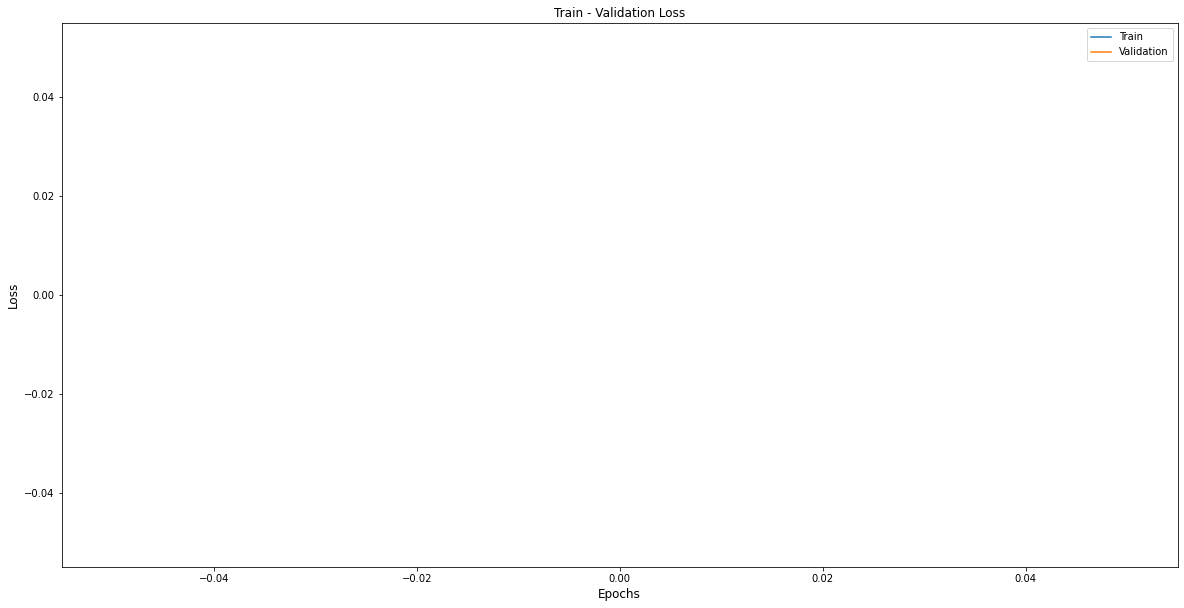

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='Best')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Unrecognized location 'Best'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  import sys


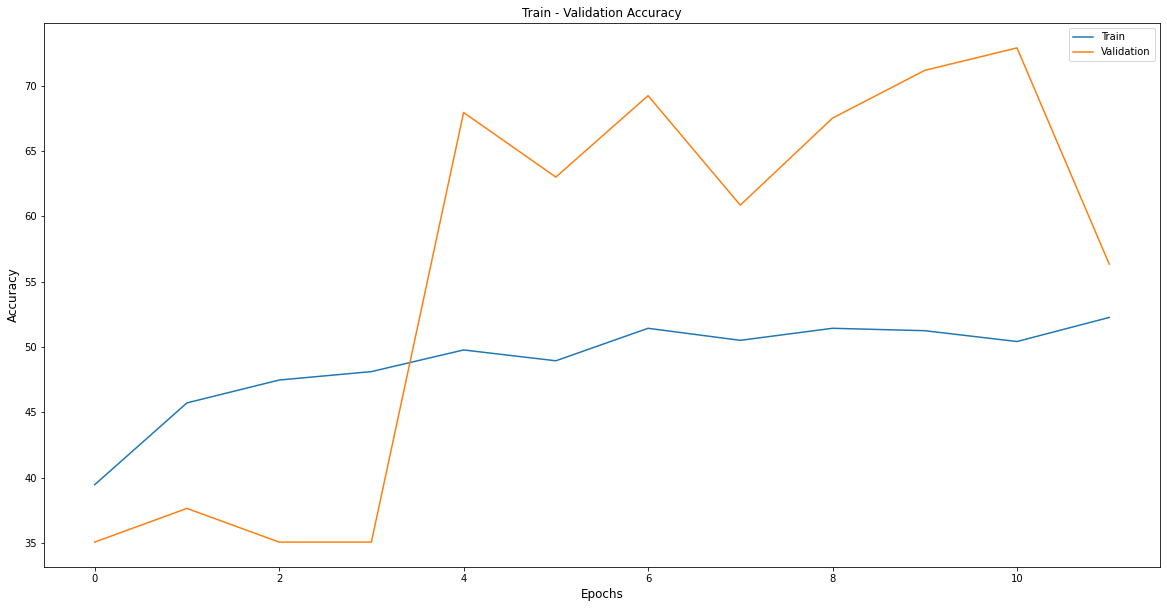

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Validation')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='Best')

In [ ]:
model.load_state_dict(torch.load('model_classification_tutorial.pt'))

<All keys matched successfully>

In [ ]:
DataIter = iter(ValidationLoader)
Images, Labels = DataIter.next()
InstrumentTypes = {0: 'Curved Mayo Scissor', 1: 'Scalpel', 2: 'Straight Mayo Scissor', 3: 'Straight Dissection Clamp'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
with torch.no_grad():
    model.eval()
    for ax, image, Label in zip(axis.flat, Images, Labels):
        ax.imshow(ImageDisplay(image)) # add image
        ImageTensor = image.unsqueeze_(0)
        Output_ = model(ImageTensor)
        print(Output_)
        Exp = nn.Softmax(dim=1)
        Prob = Exp(Output_)
        print(Prob)
        HighestProb = torch.max(Prob)
        HighestProbOutput = 100 * HighestProb
        Output_ = Output_.argmax()
        ax.set_title(str(InstrumentTypes[Output_.item()])+":"+str(HighestProbOutput)+"%")


NameError: ignored